<a href="https://colab.research.google.com/github/427paul/Machine_Learning/blob/main/DL_3_1_%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification : 2 Class**


## **1.환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [3]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정(드롭아웃 및 배치 정규화와 같은 계층을 훈련 모드로 변경)
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # X.to(device), y.to(device): 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 이동

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [5]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [6]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [7]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### (4) 데이터로딩

In [8]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/titanic.3.csv"
data = pd.read_csv(path)
data.drop(['Age_scale1', 'AgeGroup', 'SibSp','Parch' ], axis = 1, inplace = True)
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


## **2.데이터 준비**

Sex, Age, Fare 만 이용하여 Survived 를 예측하는 모델을 만들어 봅시다.

### (1) 데이터 준비

In [9]:
target = 'Survived'
features = ['Sex', 'Age', 'Fare']
x = data.loc[:, features]
y = data.loc[:, target]

### (2) 가변수화

In [10]:
x = pd.get_dummies(x, columns = ['Sex'], drop_first = True)
x.head()

,Age,Fare,Sex_male
0,22.0,7.2500,True
1,38.0,71.2833,False
2,26.0,7.9250,False
3,35.0,53.1000,False
4,35.0,8.0500,True


### (3) 데이터분할

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 20)

### (4) Scaling

In [12]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## **3.모델링1**

### (1) 딥러닝을 위한 준비작업

* make_DataLoader

In [13]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [14]:
# 첫번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f"Shape of x [rows, columns]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [rows, columns]: torch.Size([32, 3])
Shape of y: torch.Size([32, 1]) torch.float32


### (2) 모델 선언

In [15]:
n_feature = x.shape[1]

# 모델 구조 설계
model = nn.Sequential(
            nn.Linear(n_feature, 1),
            nn.Sigmoid()                # [회귀와 다른점] 시그모이드 활성화 함수 추가
        ).to(device)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
  (1): Sigmoid()
)


* Loss function과 Optimizer

In [16]:
loss_fn = nn.BCELoss()          # [회귀와 다른점] Bineary Cross Entropy
optimizer = Adam(model.parameters(), lr=0.01)

### (3) 학습

In [17]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 0.653132, val loss : 0.629173
Epoch 2, train loss : 0.630931, val loss : 0.610446
Epoch 3, train loss : 0.613835, val loss : 0.594948
Epoch 4, train loss : 0.597587, val loss : 0.581932
Epoch 5, train loss : 0.587999, val loss : 0.571424
Epoch 6, train loss : 0.575908, val loss : 0.561439
Epoch 7, train loss : 0.564925, val loss : 0.552613
Epoch 8, train loss : 0.554331, val loss : 0.544851
Epoch 9, train loss : 0.550895, val loss : 0.538124
Epoch 10, train loss : 0.539508, val loss : 0.533414
Epoch 11, train loss : 0.536224, val loss : 0.527991
Epoch 12, train loss : 0.531854, val loss : 0.524290
Epoch 13, train loss : 0.533500, val loss : 0.521165
Epoch 14, train loss : 0.522871, val loss : 0.518838
Epoch 15, train loss : 0.521302, val loss : 0.516015
Epoch 16, train loss : 0.513084, val loss : 0.514293
Epoch 17, train loss : 0.512906, val loss : 0.511611
Epoch 18, train loss : 0.512027, val loss : 0.510224
Epoch 19, train loss : 0.508276, val loss : 0.509448
Ep

* 학습된 파라미터 확인

In [18]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[-0.2582,  4.7483, -2.3741]])
Parameter: 0.bias, Value: tensor([0.7973])


* 학습 곡선

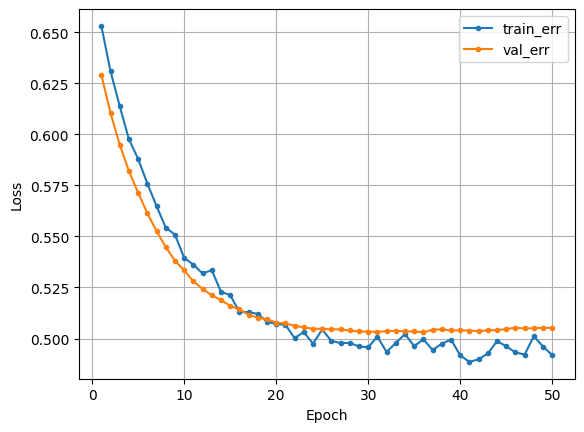

In [19]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [20]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

* **[회귀와 다른점]** 예측결과는 0 ~ 1 사이의 확률값
    * 확률값을 0, 1로 변환 필요
    * np.where(조건문, True일때 값, False일때 값)

In [21]:
pred.numpy()[:5]

array([[0.6966428 ],
       [0.15703408],
       [0.1999862 ],
       [0.17317528],
       [0.69589037]], dtype=float32)

In [22]:
pred = np.where(pred.numpy() > .5, 1, 0)
pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

* confusion matrix

In [23]:
confusion_matrix(y_val_ts.numpy(), pred)

array([[141,  29],
       [ 31,  67]])

* classification_report

In [24]:
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82       170
         1.0       0.70      0.68      0.69        98

    accuracy                           0.78       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268



## **4.딥러닝2 : 전체 feature**
* 이제 전체 데이터를 가지고 모델링을 시도해 보겠습니다.


### (1) 데이터 전처리

* 데이터 준비

In [25]:
target = 'Survived'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화

In [26]:
cat_cols = ['Pclass','Sex', 'Embarked']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

* 데이터분할

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 20)

* 스케일링

In [28]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 모델링

#### 1) 딥러닝을 위한 준비작업

* make_DataLoader

In [29]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [30]:
# 첫번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f"Shape of x [rows, columns]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [rows, columns]: torch.Size([32, 8])
Shape of y: torch.Size([32, 1]) torch.float32


#### 2) 모델 선언

In [31]:
n_feature = x.shape[1]

# 모델 구조 설계
model = nn.Sequential(
                nn.Linear(n_feature, 1),
                nn.Sigmoid()                # 시그모이드 활성화 함수 추가
        ).to(device)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=1, bias=True)
  (1): Sigmoid()
)


* Loss function과 Optimizer

In [32]:
loss_fn = nn.BCELoss()           # Bineary Cross Entropy
optimizer = Adam(model.parameters(), lr = 0.01)

#### 3) 학습

In [34]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 0.712780, val loss : 0.663963
Epoch 2, train loss : 0.645247, val loss : 0.622333
Epoch 3, train loss : 0.618306, val loss : 0.603577
Epoch 4, train loss : 0.599327, val loss : 0.586866
Epoch 5, train loss : 0.582008, val loss : 0.573925
Epoch 6, train loss : 0.566510, val loss : 0.561619
Epoch 7, train loss : 0.548386, val loss : 0.551499
Epoch 8, train loss : 0.540520, val loss : 0.542241
Epoch 9, train loss : 0.531914, val loss : 0.534360
Epoch 10, train loss : 0.522932, val loss : 0.528227
Epoch 11, train loss : 0.514417, val loss : 0.522605
Epoch 12, train loss : 0.506464, val loss : 0.517761
Epoch 13, train loss : 0.505993, val loss : 0.513583
Epoch 14, train loss : 0.499059, val loss : 0.509916
Epoch 15, train loss : 0.491804, val loss : 0.507198
Epoch 16, train loss : 0.488440, val loss : 0.503249
Epoch 17, train loss : 0.485686, val loss : 0.500859
Epoch 18, train loss : 0.484500, val loss : 0.498734
Epoch 19, train loss : 0.476038, val loss : 0.496136
Ep

* 학습된 파라미터 확인

In [35]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[-0.8964,  3.8778, -0.8708, -0.2159, -1.3558, -2.3127,  0.5019, -0.0873]])
Parameter: 0.bias, Value: tensor([1.8300])


* 학습 곡선

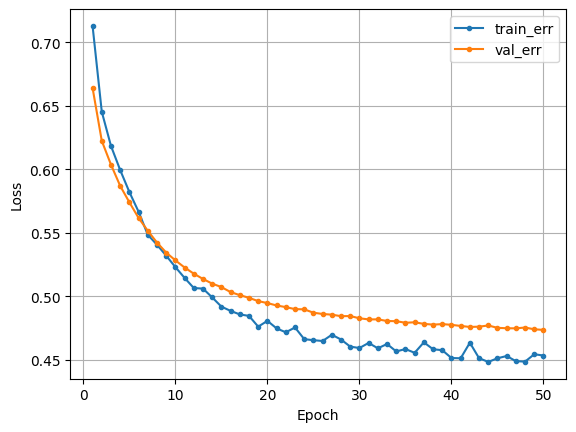

In [36]:
dl_learning_curve(tr_loss_list, val_loss_list)

#### 4) 모델 평가

In [37]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

In [38]:
pred = np.where(pred.numpy() > .5, 1, 0)

* confusion matrix

In [39]:
confusion_matrix(y_val_ts.numpy(), pred)

array([[142,  28],
       [ 33,  65]])

* classification_report

In [40]:
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82       170
         1.0       0.70      0.66      0.68        98

    accuracy                           0.77       268
   macro avg       0.76      0.75      0.75       268
weighted avg       0.77      0.77      0.77       268



----

## **5.딥러닝3 : hidden layer**
* 이제 레이어를 추가해 보겠습니다.


### (1) 모델 선언

In [41]:
n_feature = x.shape[1]

# 모델 구조 설계
model = nn.Sequential(
            nn.Linear(n_feature, 5),    # 은닉층(입력된 변수 8개 -> 5개)
            nn.ReLU(),                          # 은닉층의 활성화함수
            nn.Linear(5, 1),            # 출력층
            nn.Sigmoid()                            # 출력층의 활성화함수(입력된 변수 5개 -> 1개)
        ).to(device)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


* Loss function과 Optimizer

In [42]:
loss_fn = nn.BCELoss()          # Bineary Cross Entropy
optimizer = Adam(model.parameters(), lr = 0.01)

### (2) 학습

In [44]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 0.687637, val loss : 0.620562
Epoch 2, train loss : 0.581429, val loss : 0.544575
Epoch 3, train loss : 0.521202, val loss : 0.501067
Epoch 4, train loss : 0.485074, val loss : 0.479383
Epoch 5, train loss : 0.460004, val loss : 0.469006
Epoch 6, train loss : 0.444769, val loss : 0.463205
Epoch 7, train loss : 0.434563, val loss : 0.461629
Epoch 8, train loss : 0.437729, val loss : 0.460594
Epoch 9, train loss : 0.431376, val loss : 0.459254
Epoch 10, train loss : 0.430679, val loss : 0.459787
Epoch 11, train loss : 0.426004, val loss : 0.457804
Epoch 12, train loss : 0.421993, val loss : 0.457456
Epoch 13, train loss : 0.424784, val loss : 0.457412
Epoch 14, train loss : 0.419262, val loss : 0.459461
Epoch 15, train loss : 0.415374, val loss : 0.457867
Epoch 16, train loss : 0.419796, val loss : 0.458563
Epoch 17, train loss : 0.419555, val loss : 0.461824
Epoch 18, train loss : 0.415511, val loss : 0.459644
Epoch 19, train loss : 0.412876, val loss : 0.459588
Ep

* 학습된 파라미터 확인

In [45]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[-1.0518e-04,  1.4880e-01, -2.7890e-01, -2.7680e-01, -2.9849e-01,
         -4.0979e-02, -1.8422e-01, -1.2199e-01],
        [-6.0924e-01,  1.6631e-01,  2.2867e-01, -4.2042e-01, -8.6565e-01,
         -3.4494e-01,  1.1305e-01, -1.1733e-02],
        [ 9.7049e-02,  1.1604e+00, -8.9776e-01,  4.2030e-01, -2.9527e-01,
         -1.3927e+00,  6.3597e-01, -1.0349e-01],
        [ 4.1103e-01,  1.1401e+00, -9.8470e-02,  5.4109e-01, -6.0029e-01,
         -1.6944e+00,  5.6716e-01, -3.2289e-01],
        [ 1.9255e+00, -1.0340e+00,  5.9608e-01,  5.8950e-01,  6.5799e-01,
          6.8740e-01,  6.2479e-01,  1.2478e-01]])
Parameter: 0.bias, Value: tensor([-0.1907,  0.8961,  0.6523,  0.7356, -0.5602])
Parameter: 2.weight, Value: tensor([[-0.1036,  1.7868,  1.2818,  1.6779, -1.4304]])
Parameter: 2.bias, Value: tensor([0.3457])


* 학습 곡선

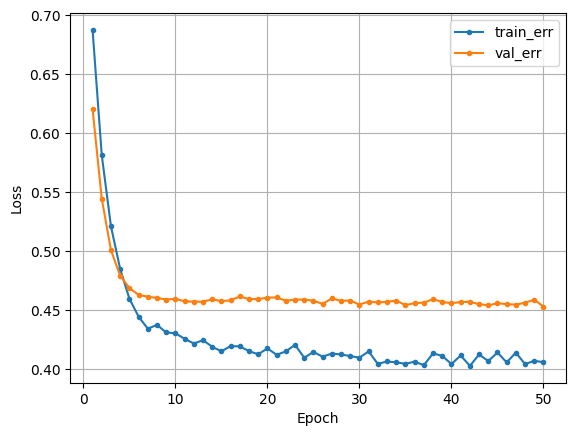

In [46]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

In [52]:
_, pred = evaluate(x_val_ts,y_val_ts, model, loss_fn, device)

In [53]:
pred =  np.where( pred.numpy() > .5, 1, 0)

* confusion matrix

In [54]:
confusion_matrix(y_val_ts.numpy(), pred)

array([[154,  16],
       [ 40,  58]])

* classification_report

In [55]:
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85       170
         1.0       0.78      0.59      0.67        98

    accuracy                           0.79       268
   macro avg       0.79      0.75      0.76       268
weighted avg       0.79      0.79      0.78       268



## **6.실습**

### (1) 실습1

* 다음의 구조를 보고 모델을 설계하시오.

        Sequential(
        (0): Linear(in_features=8, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=5, bias=True)
        (3): ReLU()
        (4): Linear(in_features=5, out_features=1, bias=True)
        (5): Sigmoid()
        )

In [56]:
n_feature = x.shape[1]

model = nn.Sequential(
    nn.Linear(n_feature, 10),
    nn.ReLU(),
    nn.Linear(10,5),
    nn.ReLU(),
    nn.Linear(5,1),
    nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
  (5): Sigmoid()
)


In [57]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 0.01)

In [58]:
epochs = 100
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 0.669360, val loss : 0.646880
Epoch 2, train loss : 0.608668, val loss : 0.565949
Epoch 3, train loss : 0.516184, val loss : 0.532815
Epoch 4, train loss : 0.487442, val loss : 0.522530
Epoch 5, train loss : 0.469231, val loss : 0.512978
Epoch 6, train loss : 0.463818, val loss : 0.493977
Epoch 7, train loss : 0.455717, val loss : 0.493461
Epoch 8, train loss : 0.449070, val loss : 0.499721
Epoch 9, train loss : 0.449586, val loss : 0.488324
Epoch 10, train loss : 0.445664, val loss : 0.479086
Epoch 11, train loss : 0.446200, val loss : 0.480643
Epoch 12, train loss : 0.446709, val loss : 0.481245
Epoch 13, train loss : 0.445318, val loss : 0.476399
Epoch 14, train loss : 0.442444, val loss : 0.473100
Epoch 15, train loss : 0.442414, val loss : 0.480774
Epoch 16, train loss : 0.449050, val loss : 0.475292
Epoch 17, train loss : 0.449177, val loss : 0.479700
Epoch 18, train loss : 0.440084, val loss : 0.473767
Epoch 19, train loss : 0.448555, val loss : 0.478258
Ep

In [59]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[-0.3665, -0.2084,  1.0218, -0.4126, -0.3306,  0.5517,  1.0777, -0.2959],
        [ 1.4007, -2.1098, -1.9499,  0.9320,  0.3460,  0.2906, -0.0789,  0.0108],
        [ 0.3883,  0.1887, -0.8506, -0.7426, -0.5535, -0.2551,  0.1703,  0.2271],
        [-0.3485, -0.3531,  0.4208, -0.2857, -0.3217,  0.1202, -0.4866, -0.4983],
        [ 0.5742,  1.8161,  0.9058,  0.2986,  0.3999,  0.2253,  0.0640,  0.3094],
        [-0.5690, -0.5909, -1.0089,  0.5514, -0.1226, -0.5152,  0.2633,  0.1749],
        [-0.2473,  0.0900,  1.4810,  0.2190, -1.7098, -0.5823,  0.3747,  0.4795],
        [-1.7810, -0.4658, -0.4029,  0.1755, -0.0550,  0.2835, -0.0562, -0.2278],
        [ 1.0361,  1.6405, -0.1776,  0.5347, -0.2067, -1.0265,  0.2623, -0.4252],
        [ 0.6532,  1.1461, -0.6948,  0.2857, -0.7143, -0.6043,  0.1598, -0.0192]])
Parameter: 0.bias, Value: tensor([-0.9004, -0.4595,  0.4987, -0.3437, -0.9121,  0.3892,  0.1579,  0.5091,
        -0.0227, -0.0833])
Parameter: 2.weigh

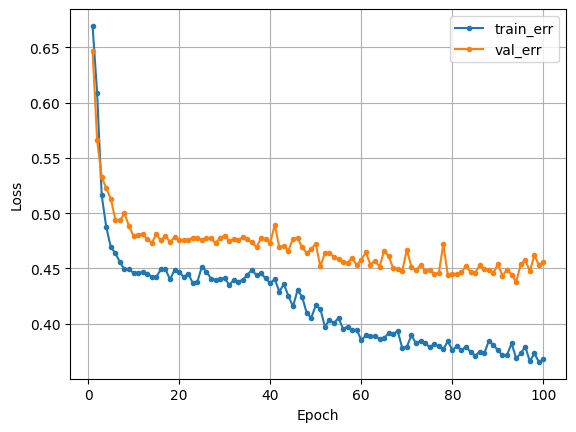

In [60]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [61]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

In [62]:
pred = np.where(pred.numpy() > .5, 1, 0)

In [63]:
confusion_matrix(y_val_ts.numpy(), pred)

array([[148,  22],
       [ 32,  66]])

In [64]:
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       170
         1.0       0.75      0.67      0.71        98

    accuracy                           0.80       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.80      0.80      0.80       268



### (2) 실습2

* 이번에는 여러분이 원하는 대로 설계하고, 학습해 봅시다.
